<a href="https://colab.research.google.com/github/hriteshMaikap/fromScratch/blob/main/final_project_INSPIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image-Text Synthesis Pipeline for Intelligent Retreival and Generation

In [ ]:
!pip install --upgrade pip --quiet
!pip install transformers==4.30.2 --quiet
!pip install timm==0.4.12 --quiet
!pip install ftfy==6.1.1 --quiet
!pip install spacy==3.4.1 --quiet
!pip install fairscale==0.4.4 --quiet
!pip install apache_beam[gcp]>=2.48.0
!pip install groq

# To use the newly installed versions, restart the runtime.
# exit()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.30.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 37.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.20 requires pydantic>=2.7.0, but you ha

In [ ]:
import requests
import os
import urllib
import json
import io
from io import BytesIO
from typing import Sequence
from typing import Iterator
from typing import Iterable
from typing import Tuple
from typing import Optional
from typing import Dict
from typing import List
from typing import Any

import apache_beam as beam
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.ml.inference.base import KeyedModelHandler
from apache_beam.ml.inference.base import PredictionResult
from apache_beam.ml.inference.base import RunInference
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerTensor
from apache_beam.ml.inference.pytorch_inference import PytorchModelHandlerKeyedTensor
from transformers import CLIPProcessor
from transformers import CLIPTokenizer
from transformers import CLIPModel
from transformers import CLIPConfig
from transformers import CLIPFeatureExtractor
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
! git lfs install
! git clone https://huggingface.co/openai/clip-vit-base-patch32

Git LFS initialized.
Cloning into 'clip-vit-base-patch32'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 54 (delta 20), reused 12 (delta 12), pack-reused 28 (from 1)
Unpacking objects: 100% (54/54), 1.60 MiB | 2.03 MiB/s, done.
Filtering content: 100% (3/3), 1.69 GiB | 42.04 MiB/s, done.


In [ ]:
# CLIP model and component configs paths
clip_feature_extractor_config_path = '/content/clip-vit-base-patch32/preprocessor_config.json'
clip_tokenizer_vocab_config_path = '/content/clip-vit-base-patch32/vocab.json'
clip_merges_config_path = '/content/clip-vit-base-patch32/merges.txt'
clip_model_config_path = '/content/clip-vit-base-patch32/config.json'
clip_state_dict_path = '/content/clip-vit-base-patch32/pytorch_model.bin'

In [ ]:
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 277 (delta 145), reused 137 (delta 137), pack-reused 94 (from 1)
Receiving objects: 100% (277/277), 7.04 MiB | 30.27 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/BLIP


In [ ]:
from BLIP.models.blip import blip_decoder

!gdown 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'
# The blip model is saved as a checkpoint, load it and save it as a state dict since RunInference required
# a state dict for model instantiation
blip_state_dict_path = '/content/BLIP/blip_state_dict.pth'
torch.save(torch.load('/content/BLIP/model*_base_caption.pth')['model'], blip_state_dict_path)

Downloading...
From: https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth
To: /content/BLIP/model*_base_caption.pth
100% 896M/896M [00:05<00:00, 174MB/s] 


In [ ]:
import os
from typing import Tuple
from PIL import Image

class ReadImagesFromDrive(beam.DoFn):
    """
    Read an image from the given file path on the local file system
    and return a tuple of the image_path and image data.
    """
    def process(self, element: str) -> Tuple[str, Image.Image]:
        image_path = os.path.join(images_path, element)  # Full path to the image
        try:
            image = Image.open(image_path).convert('RGB')  # Read and convert to RGB
            return [(element, image)]
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return []


In [ ]:
class ReadImagesFromUrl(beam.DoFn):
  """
  Read an image from a given URL and return a tuple of the images_url
  and image data.
  """
  def process(self, element: str) -> Tuple[str, Image.Image]:
    response = requests.get(element)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    return [(element, image)]

class ReadImagesFromPath(beam.DoFn):
    """
    Read an image from a given file path and return a tuple of the file path
    and image data.
    """
    def process(self, element: str) -> Tuple[str, Image.Image]:
        # Read the image from the provided file path
        image = Image.open(element).convert('RGB')
        return [(element, image)]

class FormatCaptions(beam.DoFn):
  """
  Print the image name and its most relevant captions after CLIP ranking.
  """
  def __init__(self, number_of_top_captions: int):
    self._number_of_top_captions = number_of_top_captions

  def process(self, element: Tuple[str, List[str]]):
    image_url, caption_list = element
    caption_list = caption_list[:self._number_of_top_captions]
    img_name = os.path.basename(image_url).rsplit('.')[0]
    print(f'Image: {img_name}')
    print(f'\tTop {self._number_of_top_captions} captions ranked by CLIP:')
    for caption_rank, caption_prob_pair in enumerate(caption_list):
      print(f'\t\t{caption_rank+1}: {caption_prob_pair[0]}. (Caption probability: {caption_prob_pair[1]:.2f})')
    print('\n')

In [ ]:
class PreprocessBLIPInput(beam.DoFn):

  """
  Process the raw image input to a format suitable for BLIP inference. The processed
  images are duplicated to the number of desired captions per image.

  Preprocessing transformation taken from:
  https://github.com/salesforce/BLIP/blob/d10be550b2974e17ea72e74edc7948c9e5eab884/predict.py
  """

  def __init__(self, captions_per_image: int):
    self._captions_per_image = captions_per_image

  def setup(self):

    # Initialize the image transformer.
    self._transform = transforms.Compose([
      transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

  def process(self, element):
    image_url, image = element
    # The following lines provide a workaround to turn off BatchElements.
    preprocessed_img = self._transform(image).unsqueeze(0)
    preprocessed_img = preprocessed_img.repeat(self._captions_per_image, 1, 1, 1)
    # Parse the processed input to a dictionary to a format suitable for RunInference.
    preprocessed_dict = {'inputs': preprocessed_img}

    return [(image_url, preprocessed_dict)]

class PostprocessBLIPOutput(beam.DoFn):
  """
  Process the PredictionResult to get the generated image captions
  """
  def process(self, element : Tuple[str, Iterable[PredictionResult]]):
    image_url, prediction = element

    return [(image_url, prediction.inference)]

In [ ]:
class PreprocessCLIPInput(beam.DoFn):

  """
  Process the image-caption pair to a format suitable for CLIP inference.

  After grouping the raw images with the generated captions, we need to
  preprocess them before passing them to the ranking stage (CLIP model).
  """

  def __init__(self,
               feature_extractor_config_path: str,
               tokenizer_vocab_config_path: str,
               merges_file_config_path: str):

    self._feature_extractor_config_path = feature_extractor_config_path
    self._tokenizer_vocab_config_path = tokenizer_vocab_config_path
    self._merges_file_config_path = merges_file_config_path


  def setup(self):

    # Initialize the CLIP feature extractor.
    feature_extractor_config = CLIPConfig.from_pretrained(self._feature_extractor_config_path)
    feature_extractor = CLIPFeatureExtractor(feature_extractor_config)

    # Initialize the CLIP tokenizer.
    tokenizer = CLIPTokenizer(self._tokenizer_vocab_config_path,
                              self._merges_file_config_path)

    # Initialize the CLIP processor used to process the image-caption pair.
    self._processor = CLIPProcessor(feature_extractor=feature_extractor,
                                    tokenizer=tokenizer)

  def process(self, element: Tuple[str, Dict[str, List[Any]]]):

    image_url, image_captions_pair = element
    # Unpack the image and captions after grouping them with 'CoGroupByKey()'.
    image = image_captions_pair['image'][0]
    captions = image_captions_pair['captions'][0]
    preprocessed_clip_input = self._processor(images = image,
                                              text = captions,
                                              return_tensors="pt",
                                              padding=True)

    image_url_caption_pair = (image_url, captions)
    return [(image_url_caption_pair, preprocessed_clip_input)]


class RankCLIPOutput(beam.DoFn):
  """
  Process the output of CLIP to get the captions sorted by ranking order.

  The logits are the output of the CLIP model. Here, we apply a softmax activation
  function to the logits to get the probabilistic distribution of the relevance
  of each caption to the target image. After that, we sort the captions in descending
  order with respect to the probabilities as a caption-probability pair.
  """

  def process(self, element : Tuple[Tuple[str, List[str]], Iterable[PredictionResult]]):
    (image_url, captions), prediction = element
    prediction_results = prediction.inference
    prediction_probs = prediction_results.softmax(dim=-1).cpu().detach().numpy()
    ranking = np.argsort(-prediction_probs)
    sorted_caption_prob_pair = [(captions[idx], prediction_probs[idx]) for idx in ranking]

    return [(image_url, sorted_caption_prob_pair)]

In [ ]:
MAX_CAPTION_LENGTH = 80
MIN_CAPTION_LENGTH = 10
# Increasing Beam search might improve the quality of the captions,
# but also results in more compute time
NUM_BEAMS = 1

In [ ]:
def blip_keyed_tensor_inference_fn(
    batch: Sequence[Dict[str, torch.Tensor]],
    model: torch.nn.Module,
    device: str,
    inference_args: Optional[Dict[str, Any]] = None,
    model_id: Optional[str] = None,
) -> Iterable[PredictionResult]:
  # By default, Beam batches inputs for bulk inference and calls model(batch)
  # Since we want to call model.generate on a single unbatched input (BLIP/CLIP
  # don't handle batched inputs), we define a custom inference function.
  captions = model.generate(batch[0]['inputs'],
                            sample=True,
                            num_beams=NUM_BEAMS,
                            max_length=MAX_CAPTION_LENGTH,
                            min_length=MIN_CAPTION_LENGTH)
  return [PredictionResult(batch[0], captions, model_id)]


BLIP_model_handler = PytorchModelHandlerKeyedTensor(
    state_dict_path=blip_state_dict_path,
    model_class=blip_decoder,
    inference_fn=blip_keyed_tensor_inference_fn,
    max_batch_size=1)

BLIP_keyed_model_handler = KeyedModelHandler(BLIP_model_handler)

In [ ]:
def clip_keyed_tensor_inference_fn(
    batch: Sequence[Dict[str, torch.Tensor]],
    model: torch.nn.Module,
    device: str,
    inference_args: Optional[Dict[str, Any]] = None,
    model_id: Optional[str] = None,
) -> Iterable[PredictionResult]:
  # By default, Beam batches inputs for bulk inference and calls model(batch)
  # Since we want to call model on a single unbatched input (BLIP/CLIP don't
  # handle batched inputs), we define a custom inference function.
  output = model(**batch[0], **inference_args)
  return [PredictionResult(batch[0], output.logits_per_image[0], model_id)]


CLIP_model_handler = PytorchModelHandlerKeyedTensor(
    state_dict_path=clip_state_dict_path,
    model_class=CLIPModel,
    model_params={'config': CLIPConfig.from_pretrained(clip_model_config_path)},
    inference_fn=clip_keyed_tensor_inference_fn,
    max_batch_size=1)

CLIP_keyed_model_handler = KeyedModelHandler(CLIP_model_handler)

In [ ]:
# Define DoFn for GIT caption generation
class GenerateGITCaptions(beam.DoFn):
    def __init__(self, captions_per_image: int):
        self._captions_per_image = captions_per_image

    def setup(self):
        from transformers import AutoProcessor, AutoModelForCausalLM
        self.processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
        self.model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def process(self, element):
        image_url, image = element
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.to(self.device)
        pixel_values = pixel_values.repeat(self._captions_per_image, 1, 1, 1)
        generated_ids = self.model.generate(pixel_values=pixel_values,
                                            max_length=MAX_CAPTION_LENGTH,
                                            num_beams=NUM_BEAMS)
        generated_captions = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
        return [(image_url, generated_captions)]

In [ ]:
# Define DoFn for ViT-GPT2 caption generation
class GenerateViTGPT2Captions(beam.DoFn):
    def __init__(self, captions_per_image: int):
        self._captions_per_image = captions_per_image

    def setup(self):
        from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
        self.model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.clean_text = lambda x: x.replace('<|endoftext|>', '').split('\n')[0]

    def process(self, element):
        image_url, image = element
        pixel_values = self.feature_extractor(images=image, return_tensors="pt").pixel_values.to(self.device)
        pixel_values = pixel_values.repeat(self._captions_per_image, 1, 1, 1)
        output_ids = self.model.generate(pixel_values=pixel_values,
                                         max_length=MAX_CAPTION_LENGTH,
                                         num_beams=NUM_BEAMS)
        captions = self.tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        captions = [self.clean_text(caption) for caption in captions]
        return [(image_url, captions)]

In [ ]:
class CombineCaptions(beam.DoFn):
    def process(self, element):
        image_url, captions_dict = element
        all_captions = []
        for model_name, captions_list in captions_dict.items():
            if captions_list:
                for caption in captions_list[0]:
                    all_captions.append(caption)
        return [(image_url, all_captions)]

In [ ]:
# Function to interact with GROQ API
def process_with_groq(image_name, captions):
    # Import GROQ client
    import os
    from groq import Groq

    # Initialize GROQ client (replace 'your_api_key' with your actual API key)
    client = Groq(
        api_key='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',
    )

    # Present the options to the user
    print(f"Please choose the type of caption you want for image '{image_name}':")
    print("1. Social Media Caption")
    print("2. ALT Text for Website")
    print("4. Caption for Image Notes")
    choice = input("Enter the number corresponding to your choice: ")

    # Map the user's choice to a description
    choice_map = {
        '1': 'Social Media Caption',
        '2': 'Alternate Short Caption for Website',
        '3': 'Caption for Image Notes'
    }

    if choice not in choice_map:
        print("Invalid choice. Please enter a number between 1 and 3.")
        return

    caption_type = choice_map[choice]

    # Prepare the prompt for the LLM
    prompt = f"You are an expert caption generator. You will be given a few sentences and given the following captions:\n\n"
    for idx, caption in enumerate(captions, 1):
        prompt += f"{idx}. {caption}\n"
    prompt += f"\nPlease generate a {caption_type.lower()}."

    # Call the GROQ LLM
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama3-70b-8192",
    )

    # Print the LLM's response
    generated_caption = chat_completion.choices[0].message.content.strip()
    print(f"\nGenerated {caption_type}:\n{generated_caption}\n")

In [ ]:
images_url = ['https://storage.googleapis.com/apache-beam-samples/image_captioning/Paris-sunset.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Wedges.jpeg',
              'https://storage.googleapis.com/apache-beam-samples/image_captioning/Hamsters.jpeg']

In [ ]:
images_path = ['/content/image1.jpg',
               '/content/image2.jpg',
               '/content/image3.jpg',
               '/content/image4.jpg']

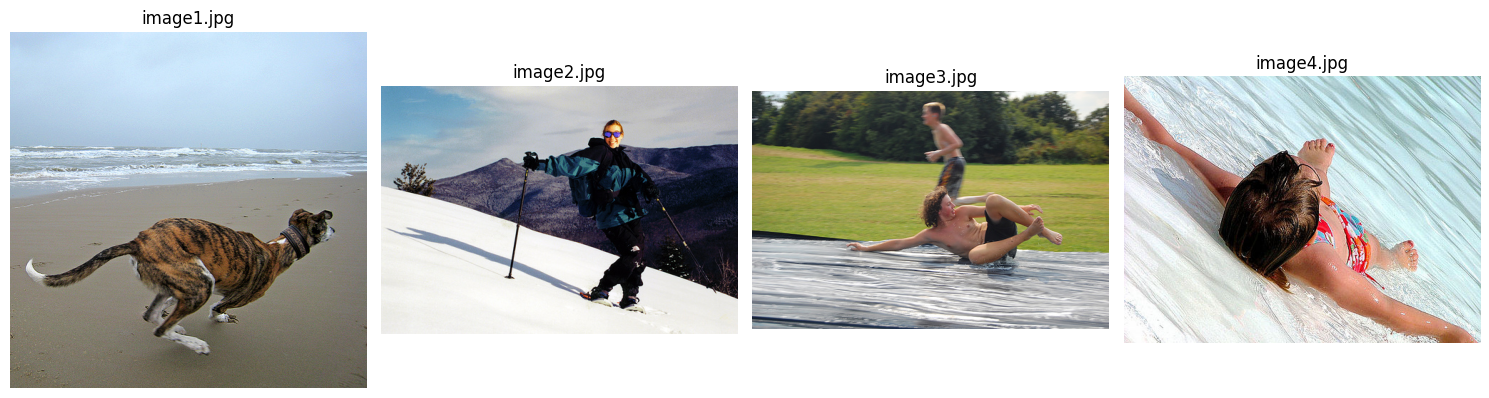

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
fig, axes = plt.subplots(1, len(images_path), figsize=(15, 5))

for ax, img_path in zip(axes, images_path):
    image = Image.open(img_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(img_path.split('/')[-1])

plt.tight_layout()
plt.show()

In [ ]:
# Number of captions generated per image.
NUM_CAPTIONS_PER_IMAGE = 10

# Number of top captions to display.
NUM_TOP_CAPTIONS_TO_DISPLAY = 3

In [ ]:
# with beam.Pipeline() as pipeline:

#   read_images = (
#             pipeline
#             | "ReadUrl" >> beam.Create(images_path)
#             | "ReadImages" >> beam.ParDo(ReadImagesFromPath()))

#   blip_caption_generation = (
#             read_images
#             | "PreprocessBlipInput" >> beam.ParDo(PreprocessBLIPInput(NUM_CAPTIONS_PER_IMAGE))
#             | "GenerateCaptions" >> RunInference(BLIP_keyed_model_handler)
#             | "PostprocessCaptions" >> beam.ParDo(PostprocessBLIPOutput()))

#   clip_captions_ranking = (
#             ({'image' : read_images, 'captions': blip_caption_generation})
#             | "CreateImageCaptionPair" >> beam.CoGroupByKey()
#             | "PreprocessClipInput" >> beam.ParDo(
#                 PreprocessCLIPInput(
#                     clip_feature_extractor_config_path,
#                     clip_tokenizer_vocab_config_path,
#                     clip_merges_config_path))
#             | "GetRankingLogits" >> RunInference(CLIP_keyed_model_handler)
#             | "RankClipOutput" >> beam.ParDo(RankCLIPOutput())
#             )

#   clip_captions_ranking | "FormatCaptions" >> beam.ParDo(FormatCaptions(NUM_TOP_CAPTIONS_TO_DISPLAY))

In [ ]:
results = []

# Rest of your imports and code remain the same...

# Modify the pipeline to collect the outputs into the results list
with beam.Pipeline() as pipeline:

    read_images = (
        pipeline
        | "ReadUrl" >> beam.Create(images_path)
        | "ReadImages" >> beam.ParDo(ReadImagesFromPath()))

    # Generate captions using BLIP
    blip_caption_generation = (
        read_images
        | "PreprocessBlipInput" >> beam.ParDo(PreprocessBLIPInput(NUM_CAPTIONS_PER_IMAGE))
        | "GenerateBLIPCaptions" >> RunInference(BLIP_keyed_model_handler)
        | "PostprocessBLIPCaptions" >> beam.ParDo(PostprocessBLIPOutput()))

    # Generate captions using GIT
    git_caption_generation = (
        read_images
        | "GenerateGITCaptions" >> beam.ParDo(GenerateGITCaptions(NUM_CAPTIONS_PER_IMAGE)))

    # Generate captions using ViT-GPT2
    vitgpt2_caption_generation = (
        read_images
        | "GenerateViTGPT2Captions" >> beam.ParDo(GenerateViTGPT2Captions(NUM_CAPTIONS_PER_IMAGE)))

    # Combine captions from all models
    combined_captions = (
        {'blip': blip_caption_generation, 'git': git_caption_generation, 'vitgpt2': vitgpt2_caption_generation}
        | "GroupCaptions" >> beam.CoGroupByKey()
        | "CombineCaptions" >> beam.ParDo(CombineCaptions()))

    # Rank the combined captions using CLIP
    clip_captions_ranking = (
        {'image': read_images, 'captions': combined_captions}
        | "CreateImageCaptionPair" >> beam.CoGroupByKey()
        | "PreprocessClipInput" >> beam.ParDo(
            PreprocessCLIPInput(
                clip_feature_extractor_config_path,
                clip_tokenizer_vocab_config_path,
                clip_merges_config_path))
        | "GetRankingLogits" >> RunInference(CLIP_keyed_model_handler)
        | "RankClipOutput" >> beam.ParDo(RankCLIPOutput())
    )

    # Collect the results into the 'results' list
    clip_captions_ranking | "CollectResults" >> beam.Map(lambda x: results.append(x))

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.9.crossattention.bias', 'decoder.transformer.h.2.attn.masked_bias', 'decoder.transformer.h.0.crossattention.bias', 'decoder.transformer.h.7.crossattention.masked_bias', 'decoder.transformer.h.4.attn.masked_bias', 'decoder.transformer.h.0.attn.masked_bias', 'decoder.transformer.h.10.crossattention.masked_bias', 'decoder.transformer.h.9.attn.bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.3.attn.bias', 'decoder.transformer.h.5.crossattention.bias', 'decoder.transformer.h.6.attn.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.11.crossattention.bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.transformer.h.4.crossattention.bias', 'decoder.transformer.h.7.attn.masked_bias', 'decoder.transformer.h.3.attn.masked_bias', 'decoder.transformer.h.10.crossatt

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# After the pipeline is done, process the results
for element in results:
    image_url, caption_list = element
    caption_list = caption_list[:NUM_TOP_CAPTIONS_TO_DISPLAY]
    img_name = os.path.basename(image_url).rsplit('.')[0]
    print(f'Image: {img_name}')
    print(f'\tTop {NUM_TOP_CAPTIONS_TO_DISPLAY} captions ranked by CLIP:')
    for caption_rank, caption_prob_pair in enumerate(caption_list):
        print(f'\t\t{caption_rank+1}: {caption_prob_pair[0]}. (Caption probability: {caption_prob_pair[1]:.2f})')
    print('\n')

    # Now, call the process_with_groq function
    captions = [pair[0] for pair in caption_list]
    process_with_groq(img_name, captions)

Image: image1
	Top 3 captions ranked by CLIP:
		1: a large brown and white dog running across a beach. (Caption probability: 0.39)
		2: a tiger dog running on a beach with water in the background. (Caption probability: 0.25)
		3: a tiger dog runs through the sand at a beach. (Caption probability: 0.06)


Please choose the type of caption you want for image 'image1':
1. Social Media Caption
2. ALT Text for Website
4. Caption for Image Notes
Enter the number corresponding to your choice: 1

Generated Social Media Caption:
Here are three different captions, one for each image:

**Image 1:**
"Sandy paws and sun-kissed fur! Who else is ready to ditch the daily grind and chase sunsets with their best bud? #beachdog #dogsofinstagram #coastalvibes"

**Image 2:**
"Tidal waves and tail wags! This tiger dog is living its best beach life! Who's with me on a beach vacation? #beachlife #dogonthebeach #furryfriend"

**Image 3:**
"Paws in the sand, nose in the air! Nothing says freedom like a beach ru

In [ ]:
# # Input 5 image paths
# images_path = []
# for i in range(5):
#     path = input(f"Enter the path to image {i + 1}: ")
#     images_path.append(path)

# print("Uploaded image paths:", images_path)

Enter the path to image 1: /content/image1.jpg
Enter the path to image 2: /content/image2.jpg
Enter the path to image 3: /content/image3.jpg
Enter the path to image 4: /content/image4.jpg
Enter the path to image 5: /content/image5.jpg
Uploaded image paths: ['/content/image1.jpg', '/content/image2.jpg', '/content/image3.jpg', '/content/image4.jpg', '/content/image5.jpg']


In [ ]:
from apache_beam.io.textio import WriteToText

csv_file_path = "/content/image_captions"

import apache_beam as beam
from apache_beam.io.textio import WriteToText

# CSV file path
csv_file_path = "/content/image_captions"

# User-defined image paths
images_path = [
    input("Enter the path to image 1: "),
    input("Enter the path to image 2: "),
    input("Enter the path to image 3: "),
    input("Enter the path to image 4: "),
]
print("Uploaded image paths:", images_path)

# FormatCaptions class to extract the best caption for each image
class FormatCaptions2(beam.DoFn):
    """
    Extract and format the best caption for each image.
    """
    def process(self, element):
        image_url, caption_list = element
        img_name = os.path.basename(image_url).rsplit('.', 1)[0]
        # Extract the best caption (top-ranked)
        best_caption = caption_list[0][0]  # First caption text
        yield f"{image_url},{best_caption}"

# Define the pipeline
with beam.Pipeline() as pipeline:
    # Read the images from user-provided paths
    read_images = (
        pipeline
        | "CreateImagePaths" >> beam.Create(images_path)
        | "ReadImages" >> beam.ParDo(ReadImagesFromPath())
    )

    # Generate captions using BLIP
    blip_caption_generation = (
        read_images
        | "PreprocessBlipInput" >> beam.ParDo(PreprocessBLIPInput(NUM_CAPTIONS_PER_IMAGE))
        | "GenerateCaptions" >> RunInference(BLIP_keyed_model_handler)
        | "PostprocessCaptions" >> beam.ParDo(PostprocessBLIPOutput())
    )

    # Rank captions using CLIP
    clip_captions_ranking = (
        ({'image': read_images, 'captions': blip_caption_generation})
        | "CreateImageCaptionPair" >> beam.CoGroupByKey()
        | "PreprocessClipInput" >> beam.ParDo(
            PreprocessCLIPInput(
                clip_feature_extractor_config_path,
                clip_tokenizer_vocab_config_path,
                clip_merges_config_path
            ))
        | "GetRankingLogits" >> RunInference(CLIP_keyed_model_handler)
        | "RankClipOutput" >> beam.ParDo(RankCLIPOutput())
    )

    # Format captions for CSV output
    formatted_captions = (
        clip_captions_ranking
        | "FormatCaptions" >> beam.ParDo(FormatCaptions2())
    )

    # Write formatted captions to a CSV file
    formatted_captions | "WriteToCSV" >> WriteToText(
        file_path_prefix=csv_file_path,
        file_name_suffix=".csv",
        header="image_path,best_caption",
        shard_name_template=""  # Avoid sharding for a single file
    )


Enter the path to image 1: /content/image1.jpg
Enter the path to image 2: /content/image2.jpg
Enter the path to image 3: /content/image3.jpg
Enter the path to image 4: /content/image4.jpg
Uploaded image paths: ['/content/image1.jpg', '/content/image2.jpg', '/content/image3.jpg', '/content/image4.jpg']


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import euclidean

# Load stored captions
csv_file_path = "/content/image_captions.csv"
captions_df = pd.read_csv(csv_file_path)

# Combine captions for vectorization
captions = captions_df['best_caption'].tolist()

# User query
user_query = input("Enter your query: ")

# Vectorize captions and the query using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(captions + [user_query])  # Includes all captions + the query

# Extract query vector and caption vectors
query_vector = tfidf_matrix[-1].toarray()[0]  # Last vector is the query
caption_vectors = tfidf_matrix[:-1].toarray()  # All vectors except the last one

# Compute Euclidean distances between the query and captions
distances = [euclidean(query_vector, caption_vector) for caption_vector in caption_vectors]

# Find the best match
best_match_index = np.argmin(distances)  # Index of the smallest distance
best_match_image_path = captions_df.loc[best_match_index, 'image_path']

print(f"Best match image path: {best_match_image_path}")


Enter your query: man sliding on water
Best match image path: /content/image3.jpg


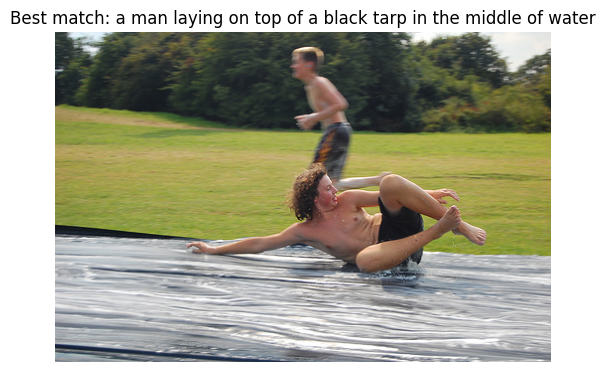

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Load and display the best match image
best_image = Image.open(best_match_image_path)

plt.imshow(best_image)
plt.axis("off")
plt.title(f"Best match: {captions_df.loc[best_match_index, 'best_caption']}")
plt.show()